<a href="https://colab.research.google.com/github/inesbsilveira/hummingbirds/blob/main/wildfires_risk_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geemap
!pip install geojson

In [8]:
import os
import csv
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from shapely.validation import make_valid
import geojson
import zipfile
import ee
import geemap
from shapely.geometry import mapping
import time

In [3]:
my_project = 'ee-ineshummingbirds'
ee.Authenticate()
ee.Initialize(project= my_project)

In [112]:

# if the input is a shapefile
country = 'Ivory Coast'
project_area_name = 'Calao' #region/country/project name
input_shp = "calao_buffer.shp"
gdf = gpd.read_file(input_shp).to_crs('EPSG:4326')
File = geemap.geopandas_to_ee(gdf)

In [113]:

# Define the date range
start_date = '2000-01-01'
end_date = '2022-12-31'
startDate = ee.Date(start_date)
endDate = ee.Date(end_date)

# Calculate the number of years to process
nYears = ee.Number(endDate.difference(startDate, 'year')).round().subtract(1)
print(f'Number of years: {nYears.getInfo()}')

# Load MODIS Burned Area dataset
sst = ee.ImageCollection("MODIS/006/MCD64A1") \
            .select('BurnDate') \
            .filterDate(startDate, endDate)

# Create a function to process burned area by year
def process_year(n):
    # Calculate the start and end date for each year
    ini = startDate.advance(n, 'year')
    end = ini.advance(1, 'year')

    # Filter the burned area collection for the given year
    result = sst.filterDate(ini, end)
    result = result.max().set('system:time_start', ini)

    # Get the burned area (where BurnDate is not 0) and mask it
    result = ee.Image.pixelArea() \
               .divide(10000) \
               .updateMask(result.neq(0))  # Mask out non-burned areas

    # Sum the area of burned forest for the year
    result = result.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=File,  # Use the converted region geometry
        scale=500,
        maxPixels=1e12,
        tileScale=4
    )

    # Extract the area burned in the forest for that year
    burnedArea = result.get('area')

    # Return the area burned in the forest for that year
    return ee.Feature(None, {'burned_area_ha': burnedArea})

# Map over each year and process the burned area
byYear = ee.FeatureCollection(
    ee.List.sequence(0, nYears).map(process_year)
)

# Print the results
print('Area (ha) burned forest by year:')
print(byYear.getInfo())


Number of years: 22
Area (ha) burned forest by year:
{'type': 'FeatureCollection', 'columns': {'burned_area_ha': 'Float', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': None, 'id': '0', 'properties': {'burned_area_ha': 15993.940422395815}}, {'type': 'Feature', 'geometry': None, 'id': '1', 'properties': {'burned_area_ha': 17682.933688088255}}, {'type': 'Feature', 'geometry': None, 'id': '2', 'properties': {'burned_area_ha': 51375.511239362866}}, {'type': 'Feature', 'geometry': None, 'id': '3', 'properties': {'burned_area_ha': 43786.661843756265}}, {'type': 'Feature', 'geometry': None, 'id': '4', 'properties': {'burned_area_ha': 11065.035490245098}}, {'type': 'Feature', 'geometry': None, 'id': '5', 'properties': {'burned_area_ha': 54372.177072628634}}, {'type': 'Feature', 'geometry': None, 'id': '6', 'properties': {'burned_area_ha': 44827.918427273224}}, {'type': 'Feature', 'geometry': None, 'id': '7', 'properties': {'burned_area_ha': 58118.53200267161}}, {'type'

In [114]:
# Extract the features from the Earth Engine FeatureCollection
features = byYear.getInfo()['features']

# Extract 'area_ha' values and their corresponding years
data = []
for feature in features:
    year = feature['id']  # The id corresponds to the year index (0-9 in your case)
    area_ha = feature['properties']['burned_area_ha']
    data.append({'year': int(year), 'burned_area_ha': area_ha})

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


    year  burned_area_ha
0      0    15993.940422
1      1    17682.933688
2      2    51375.511239
3      3    43786.661844
4      4    11065.035490
5      5    54372.177073
6      6    44827.918427
7      7    58118.532003
8      8    33747.360066
9      9    48892.319081
10    10    35779.973958
11    11    35116.493235
12    12    28134.077429
13    13    54513.929525
14    14    23391.044100
15    15    15052.857429
16    16    23782.446443
17    17    24987.765914
18    18    30902.887173
19    19    10283.217639
20    20    17339.665368
21    21    15409.994462
22    22    18153.531555


In [105]:
def get_shapefile_centroid(gdf):
    """Ensure CRS is geographic and return the centroid coordinates."""
    if gdf.crs is None or gdf.crs.is_projected:
        gdf = gdf.to_crs(epsg=4326)  # Convert to WGS84 (lat/lon)

    centroid = gdf.unary_union.centroid
    return centroid.y, centroid.x  # (latitude, longitude)

def get_best_crs(latitude, longitude):
    """ Returns the best UTM zone EPSG code based on latitude """
    utm_zone = int((180 + longitude) / 6) + 1
    return f"EPSG:{32600 + utm_zone if latitude >= 0 else 32700 + utm_zone}"

In [115]:
latitude, longitude = get_shapefile_centroid(gdf)
#print(f"Central Point: ({latitude}, {longitude})")
best_epsg = get_best_crs(latitude, longitude)  # Replace with actual latitude
print(best_epsg)

EPSG:32630


<ipython-input-105-8622922bd85d>:6: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centroid = gdf.unary_union.centroid


In [116]:
gdf_crs = gdf.to_crs(best_epsg)
total_area_ha = (gdf_crs['geometry'].area/10000).sum()
print(f"Total area in hectares: {total_area_ha}")

Total area in hectares: 165545.93989969188


In [117]:
# Add a new column to the DataFrame that represents the percentage of burned area
df['burned_area_percentage'] = (df['burned_area_ha'] / total_area_ha) * 100

# Display the updated DataFrame
print(df)

    year  burned_area_ha  burned_area_percentage
0      0    15993.940422                9.661331
1      1    17682.933688               10.681587
2      2    51375.511239               31.033990
3      3    43786.661844               26.449855
4      4    11065.035490                6.683967
5      5    54372.177073               32.844162
6      6    44827.918427               27.078839
7      7    58118.532003               35.107193
8      8    33747.360066               20.385495
9      9    48892.319081               29.533989
10    10    35779.973958               21.613320
11    11    35116.493235               21.212537
12    12    28134.077429               16.994725
13    13    54513.929525               32.929789
14    14    23391.044100               14.129639
15    15    15052.857429                9.092858
16    16    23782.446443               14.366071
17    17    24987.765914               15.094158
18    18    30902.887173               18.667258
19    19    10283.21

In [118]:
# Calculate mean and standard deviation for area burned in hectares
mean_area = df['burned_area_ha'].mean()
std_area = df['burned_area_ha'].std()
print(mean_area)
print(std_area)

mean_area_percentage = df['burned_area_percentage'].mean()
std_area_percentage = df['burned_area_percentage'].std()
print(mean_area_percentage)
print(std_area_percentage)

30987.403198372784
15380.613816036524
18.718310589283416
9.290843270065093


In [120]:
#TIME SINCE LAST FIRE
# Sort data by year (ensure it's sorted)
df = df.sort_values('year', ascending=True)
big_fire_threshold = mean_area + (std_area)

# Find the most recent year with a big fire
big_fires = df[df['burned_area_ha'] >= big_fire_threshold]
if not big_fires.empty:
    last_big_fire_year = big_fires['year'].max()
else:
    last_big_fire_year = None  # No big fire found

# Get the current year (assuming the latest year in the dataset is the most recent)
current_year = df['year'].max()

# Calculate how many years ago the last big fire occurred
if last_big_fire_year:
    years_since_last_big_fire = current_year - last_big_fire_year
else:
    years_since_last_big_fire = float('inf')  # If no fire, treat as very long ago

# Determine risk level
if years_since_last_big_fire <= 5:
    risk_level = "High risk"
elif 5 < years_since_last_big_fire <= 10:
    risk_level = "Medium risk"
else:
    risk_level = "Low risk"


# Filter the dataframe to get only the big fires
big_fires = df[df['burned_area_ha'] >= big_fire_threshold]

# Count the number of big fires
num_big_fires = len(big_fires)

print(f"Total number of big fires: {num_big_fires}")
print(f"Year of last big fire: 20{last_big_fire_year}")
print(f"Nr of years since last big fire: {years_since_last_big_fire}")
print(f"Fire risk: {risk_level}")

Total number of big fires: 5
Year of last big fire: 2013
Nr of years since last big fire: 9
Fire risk: Medium risk


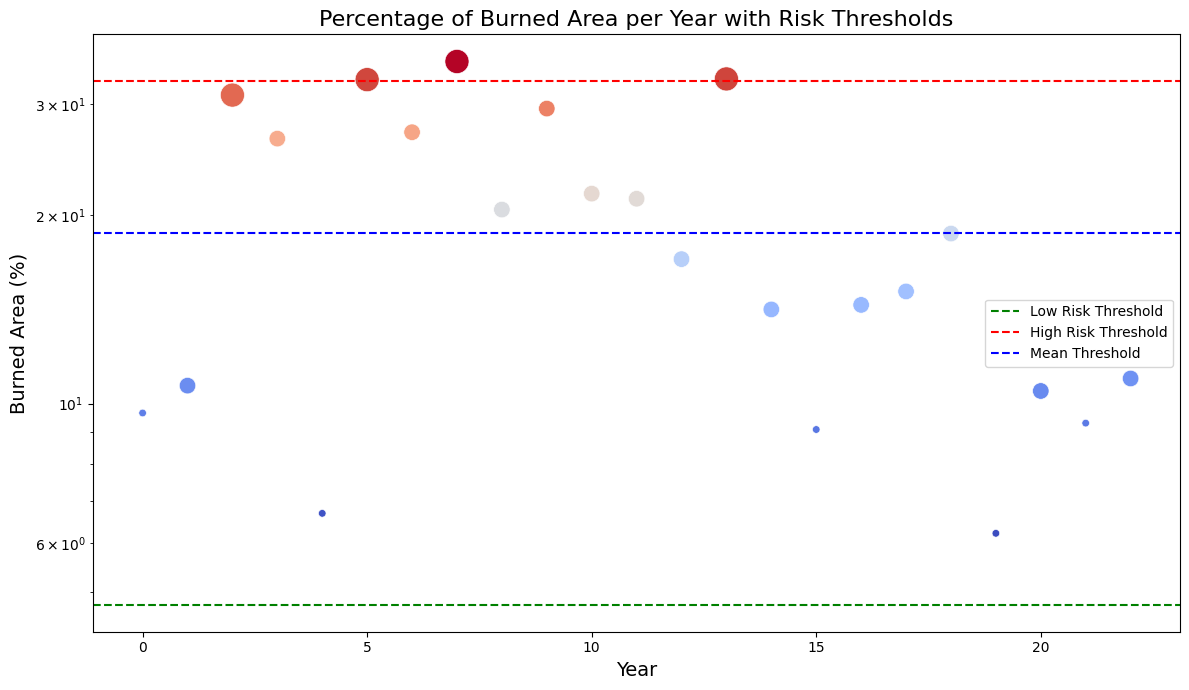

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate thresholds for risk levels
mean_area = df['burned_area_percentage'].mean()
std_area = df['burned_area_percentage'].std()

low_risk_threshold = mean_area - (1.5*std_area)
high_risk_threshold = mean_area + (1.5*std_area)
mean_threshold = mean_area
# Categorize the point sizes based on the area burned
def size_category(burned_area_percentage):
    if burned_area_percentage < 10:
        return 30  # Small
    elif 10 <= burned_area_percentage < 30:
        return 100  # Medium
    elif 30 <= burned_area_percentage < 50:
        return 200  # Medium-large
    else:
        return 300  # Large

# Apply the size category function to the 'burned_area_ha' column
df['point_size'] = df['burned_area_percentage'].apply(size_category)

# Create the scatter plot
plt.figure(figsize=(12, 7))
sns.scatterplot(data=df, x='year', y='burned_area_percentage', size='point_size', sizes=(30, 300),
                hue='burned_area_percentage', palette='coolwarm', legend=False)

# Add horizontal lines for risk thresholds
plt.axhline(y=low_risk_threshold, color='green', linestyle='--', label='Low Risk Threshold')
plt.axhline(y=high_risk_threshold, color='red', linestyle='--', label='High Risk Threshold')
plt.axhline(y=mean_threshold, color='blue', linestyle='--', label='Mean Threshold')

# Set labels and title
plt.title('Percentage of Burned Area per Year with Risk Thresholds', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Burned Area (%)', fontsize=14)
plt.yscale('log')

# Show legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


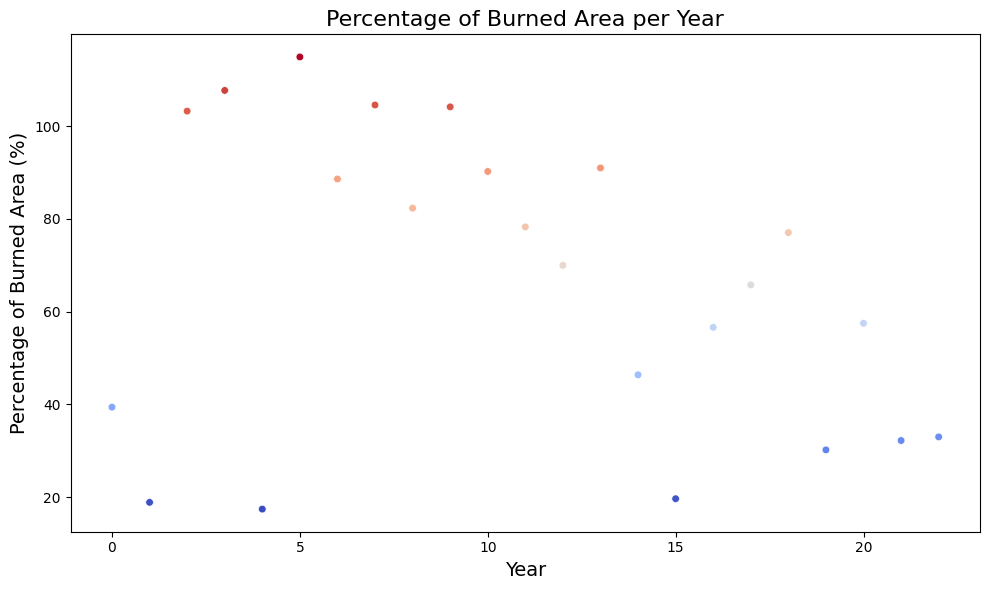

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' contains the 'year', 'percentage_burned', and 'area_burned(ha)' columns
# Categorize the point sizes based on the area burned
def size_category(area):
    if area < 300:
        return 30  # Small
    elif 300 <= area < 500:
        return 100  # Medium
    elif 500 <= area < 1000:
        return 200  # Medium-large
    else:
        return 300  # Large

# Apply the size category function to the 'area_burned(ha)' column
df['point_size'] = df['burned_area_ha'].apply(size_category)

# Create the plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='year', y='burned_area_percentage', size='point_size', sizes=(30, 300), hue='burned_area_percentage', palette='coolwarm', legend=False)

# Set the labels and title
plt.title('Percentage of Burned Area per Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage of Burned Area (%)', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()
